In [1]:
%reload_ext autoreload
%autoreload 2
#from fastai import * 
from fastai.text import * 
import sentencepiece as spm

In [2]:
lang            = "en"
pathData       = Path("../nlp-data")
path           = pathData / lang
pathTrainValid = path/"wiki-train_valid"
spCache        = "sp-model"
pathSPVocab    = pathTrainValid / spCache

In [3]:
def usedGB_RAM(): 
    import psutil
    return round((psutil.virtual_memory().used + psutil.swap_memory().used)/1e9,2)

# Data preparation

Load the training and validation data we prepared in wiki_preparation.ipynb. In total 100 million articles with a split of 80% / 20% for training/validation:
- First column: text content to train the model. 
- Second column: Boolean representing if the data is for training or validation.

# Create Tokenizer
The sentencepiece vocabulary was trained in Train Sentencepiece tokenizer.ipynb.

Here we will make a BasicTokenizer from Sentencepiece so that fastai can use it instead of spacy

In [5]:
class SentencepieceTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        path,cache_name = pathTrainValid, "sp-model"
    #def __init__(self, path:PathOrStr, cache_name:str='sp-model'):
        self.pathVocab = path / cache_name
        self.vocab_    = Vocab(pickle.load(open(self.pathVocab/'itos.pkl', 'rb')))
        self.tok       = spm.SentencePieceProcessor()
        
        self.tok.Load(str(Path(path) / cache_name / 'm.model'))
        text.transform.UNK = "<unk>"

    #def __call__(self, language:str): return self    
        
    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
    def add_special_cases(self, toks:Collection[str]):
        #this should have been done when training sentencepiece
        pass
    
    def vocab(self): return self.vocab_

In [6]:
spt       = SentencepieceTokenizer(lang="en")
tokenizer = Tokenizer(SentencepieceTokenizer,"en")
pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab  = spt.vocab(), len(spt.vocab().itos)

print(tokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
sentence = ["She is tall.", "He is small"]
tokenizer._process_all_1(sentence)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]


[['▁she', '▁is', '▁tall', '.'], ['▁he', '▁is', '▁small']]

# LM Training


We train two LM: one with a 60k vocabulary and one with a 30k vocabulary. The two models have different performance and computation needs.

In [7]:
#Discard section with kess than "minTok" tokens
minToks=10

In [8]:
a= [0,1,2,3.1]
json.dumps(a)
str(np.asarray(a))

'[0.  1.  2.  3.1]'

In [9]:
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool 

In [10]:
#import asyncio
class FileTokenizer():
    "Put together rules and a tokenizer function to tokenize text with multiprocessing."
    def __init__(self, tokPath:Path, tok_func:Callable, lang:str, vocab:Vocab=vocab, pre_rules:ListRules=None,
                 post_rules:ListRules=None, special_cases:Collection[str]=None, n_cpus:int=None):
        self.tok_func,self.lang,self.special_cases = tok_func,lang,special_cases
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        self.post_rules = ifnone(post_rules, defaults.text_post_rules )
        self.special_cases = special_cases if special_cases else defaults.text_spec_tok
        self.n_cpus = ifnone(n_cpus, defaults.cpus)
        self.vocab  = vocab
        self.tokPath = tokPath
        
        self.count=0

    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} in {self.lang} with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        for rule in self.post_rules: res += f' - {rule.__name__}\n'
        return res

    def process_text(self, t:str, tok:BaseTokenizer) -> List[str]:
        "Process one text `t` with tokenizer `tok`."
        inPath = Path(t)
        if not inPath.exists(): 
            print(f"file does not exist{str(inPath)}")
            return ""
        
        pathIds = self.tokPath/(inPath.stem+"-ids.npy")
        pathIds.parent.mkdir(parents=True,exist_ok=True)
        
        arrays = []
        with inPath.open("r") as f:
            for line in f:
                for rule in self.pre_rules: line = rule(line)
                toks = tok.tokenizer(line)
                for rule in self.post_rules: toks = rule(toks)
                ids = vocab.numericalize(toks) 
                
                if len(toks) < minToks: continue
                arrays.append( np.asarray(ids, dtype=np.int16) )
        
        if len(arrays)>0:
            with pathIds.open("wb") as f:
                np.save(f, arrays, allow_pickle=True, fix_imports=False)
                
        return t

    def _process_all_1(self, texts:Collection[str]) -> List[List[str]]:
        "Process a list of `texts` in one process."
        tok = self.tok_func(self.lang)
        if self.special_cases: tok.add_special_cases(self.special_cases)
        return [self.process_text(t, tok) for t in texts]

    def process_all(self, texts:Collection[str]) -> List[List[str]]:
        "Process a list of `texts`."
        print("FileTokenizer process_all")
        
        if self.n_cpus <= 1: return self._process_all_1(texts)
        print(f"cpus: {self.n_cpus} number of files:{len(texts)}")
        with ProcessPoolExecutor(self.n_cpus) as e:
            #return e.map(self._process_all_1, partition_by_cores(texts, self.n_cpus))
            return sum(e.map(self._process_all_1, partition_by_cores(texts, self.n_cpus)), [])
        
    @staticmethod
    def getIds_from_file(files):
        idArrays=[]
        for fp in files:
            with fp.open("rb") as f:
                a = np.load(f)
                if len(a) > 0: idArrays.extend( a )
        return idArrays 
    
    def getIds(self, n_cpus=defaults.cpus):
        #threading does not help on speed in this case :(
        files = list(self.tokPath.glob("*-ids.npy"))
        
        #3use_cores = max(1,defaults.cpus)
        print(f"threading with on {n_cpus} cores")
        
        pool = ThreadPool(n_cpus) 
        results = pool.map(FileTokenizer.getIds_from_file, partition_by_cores(files, n_cpus))
        pool.close() 
        pool.join()
        
        idArrays=[]
        for a in results:idArrays.extend(a)
        idArrays = np.asarray(idArrays,dtype=object)    
        return idArrays 


In [11]:
class FileTokenizeProcessor(PreProcessor):
    "`PreProcessor` that tokenizes the texts in `ds`."
    def __init__(self, ds:ItemList=None, tokenizer:Tokenizer=None, chunksize:int=10000, mark_fields:bool=False):
        self.tokenizer,self.chunksize,self.mark_fields = ifnone(tokenizer, Tokenizer()),chunksize,mark_fields

    def process_one(self, item):  return self.tokenizer._process_all_1([item])[0]
    def process(self, ds):
        print("FileTokenizeProcessor process")
        #ds.items = _join_texts(ds.items, self.mark_fields)
        self.tokenizer.process_all(ds.items)
        #ds.items = self.tokenizer.process_all(ds.items)
        #ds.items = tokens


In [12]:
pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer = FileTokenizer(pathTrainValid/"toks/train", SentencepieceTokenizer,"en",vocab)
validTokenizer = FileTokenizer(pathTrainValid/"toks/valid", SentencepieceTokenizer,"en",vocab)

print(trainTokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
#sentence = ["She is tall.", "He is small"]
#tokenizer._process_all_1(sentence)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]


In [13]:
#import timeit start = timeit.default_timer()
pathTxt = pathTrainValid/"txt"
files   = np.asarray( list(pathTxt.glob("*.txt")) )
nrows   = len(files)
split   = 0.2
splitindex, index = int(nrows*split+.5), np.random.permutation(np.arange(nrows)) 

chunksize=0

trainList = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                     processor=[FileTokenizeProcessor(tokenizer=trainTokenizer, chunksize=chunksize, mark_fields=False)] )
validList = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                     processor=[FileTokenizeProcessor(tokenizer=validTokenizer, chunksize=chunksize, mark_fields=False)] )
#print(timeit.default_timer()-start )

In [14]:
print("1 nb: used GB memory:", usedGB_RAM()) 
%time trainIDS = trainTokenizer.getIds(n_cpus=2)

1 nb: used GB memory: 3.51
threading with on 2 cores
CPU times: user 2min 26s, sys: 16.7 s, total: 2min 43s
Wall time: 2min 34s


In [15]:
%time validIDS = validTokenizer.getIds(n_cpus=1)
print("2 nb: used GB memory:", usedGB_RAM()) 

threading with on 1 cores
CPU times: user 35.4 s, sys: 3.46 s, total: 38.8 s
Wall time: 39.4 s
2 nb: used GB memory: 7.96


In [16]:
print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{np.sum([len(ids) for ids in trainIDS])}")
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{np.sum([len(ids) for ids in validIDS])}")

Traning:    number of arrays:25527730 - number of ids:2046492393
Validation: number of arrays:8504038 - number of ids:733295647


min:1 max:12985 - median:63.0
1521907


array([134,  71,  70,  16,  35,  39, 269, 261, 146,  89,  39,  43,  42,  20,  33, 132,  87,  67,  12,  36], dtype=int32)

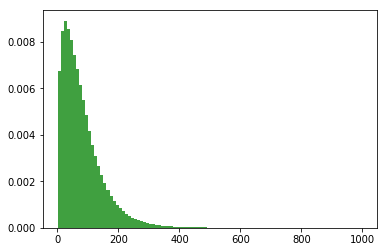

In [17]:
"Analyse the distribution of the legnth of tokens sequences in the ragged/jagged array of tokes
sectionlengths   = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
plt.hist(sectionlengths[sectionlengths<1000], 100, density=True, facecolor='g', alpha=0.75)
np.histogram(sectionlengths[sectionlengths<1000],50)

print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
print(np.sum(sectionlengths<10))
sectionlengths[:20]

In [18]:
class MyLanguageModelLoader():
    "Create a dataloader with bptt slightly changing."
    
    class CircularIndex():
        def __init__(self, length:int): 
            self.idx = np.arange(length)
            self.forward_ = True
        #when the index exceeds the length of self.idx then is is wrap to start indexing at the head
        #if the index is backwards then start at the end and wraps if necessary at head to continue
        def __getitem__(self, i): 
            index = i%len(self.idx) if self.forward_ else len(self.idx)-1 - i%len(self.idx)
            return self.idx[index]
        def __len__(self) -> int: return len(self.idx)
        def shuffle(self): np.random.shuffle(self.idx)
        def forward(self, forward:bool=True): self.forward_ = forward
                
    def __init__(self, dataset:LabelList, bs:int=64, bptt:int=70, backwards:bool=False, shuffle:bool=False,
                 max_len:int=25, p_bptt:int=0.95):
        self.init_kwargs = dict(bs=bs, bptt=bptt, backwards=backwards, shuffle=shuffle, max_seq=max_len)
        self.dataset,self.bs,self.bptt,self.backwards,self.shuffle,self.p_bptt = dataset,bs,bptt,backwards,shuffle,p_bptt
        
        #self.idx simplifies calculation of self.ite_len and the batch loop were seq_len varies uniformly
        #idx is used to index the raggged dataset. 
        #It can be shuffle in-place 
        #The indexing is circular in order to stay within self.dataset.x.items
        self.idx = MyLanguageModelLoader.CircularIndex(len(self.dataset))
        self.idx.forward( self.backwards==False ) 
        
        nToks = 0
        for s in dataset.x.items: nToks+=len(s)
        self.ite_len = math.ceil( nToks / (self.bs*self.bptt) ) #this is returned in def __len__(self) 
        
        #The first batch has length = 2*self.bptt as in the original code
        self.first_seq_len = 2*self.bptt
        #The following batches vary uniformly around bppt as defined by p_bptt
        seq_other = math.ceil( self.bptt*(1+0.5*self.p_bptt) )
        
        #allocate the required worth-case batchbuffer 
        max_batch_element = self.bs*( max(self.first_seq_len, seq_other) +1 )
        self.buffer       = np.zeros(max_batch_element, dtype=np.long)
        
        #self.min_seq,self.max_seq = 5,max_len #self.min_seq, self.max_seq is no longer used
        self.num_workers = 0

        print(f"LanguageModelLoader.__init__ Used GB memory:{usedGB_RAM()} batches:{len(self)} nToks:{nToks} "+\
              f"bptt:{self.bptt} p_bptt:{self.p_bptt} shuffle:{self.shuffle} backwards:{self.backwards}" )  
        
    def __iter__(self):
        if getattr(self.dataset, 'item', None) is not None: 
            yield LongTensor(getattr(self.dataset, 'item'))[None],LongTensor([0])
        if self.shuffle: self.idx.shuffle()

        i,self.ei,self.eo = 0,0,1
        while i < self.ite_len:
            seq_len = self.first_seq_len if i==0 else int(self.bptt*(1. + self.p_bptt*(np.random.random() - 0.5)))
            nToks   = self.bs*(seq_len+1)
            
            self.fill_buffer(nToks)
            data  = torch.from_numpy( self.buffer[:nToks].reshape(self.bs,-1) )
            res   = data[:,0:seq_len-1], data[:,1:seq_len]        
            i    += 1
            #if i==self.ite_len : print(res) # check that y is shift to predict x       
            yield res
            
    
    def fill_buffer(self, nToks:int):
        "new the tokens in the buffer with nToks from the ragged array"
        #nToks: number of tokens to be extract and inserted starting at the beginning of the buffer from the 
        #       last saved indices in the ragged array and forward - possibly wrapping to the head of the dataset
        #bi: index of the first rag to be extract
        #bo: index where the extraction starts in the first rag
        #ei: index of the last rag to be extract
        #bo: index (not inclusive) where the extract stops in the last rag
        
        j, bi, bo, csum, ibuf = self.ei, self.ei, self.eo-1, 0, 0
        while nToks > csum:   
            rag   = self.dataset.x.items[self.idx[j]]
            rl    = (len(rag)-bo) if j==bi else len(rag) 
            csum += rl        
            if nToks <= csum: 
                self.ei = j
                self.eo = ( nToks-(csum-rl) ) if j>bi else (nToks-(csum-rl) + bo)
                r       = (bo,self.eo) if bi==self.ei else (0,self.eo)
            else: 
                r       = (bo,len(rag)) if j==self.ei else (0,len(rag))            
            self.buffer[ibuf:ibuf+r[1]-r[0]] = rag[r[0]:r[1]]
            ibuf += r[1]-r[0]
            j    += 1      
        #print( f"nToks:{nToks} nBToks:{ibuf} bi:{bi} bo:{bo} ei:{self.ei} eo:{self.eo}" )        

    def __len__(self) -> int: return self.ite_len
    def __getattr__(self,k:str)->Any: return getattr(self.dataset, k)

    @property
    def batch_size(self): return self.bs
    @batch_size.setter
    def batch_size(self, v): self.bs = v

    def batchify(self, data:np.ndarray) -> LongTensor: pass

class MyTextLMDataBunch(TextLMDataBunch):
    "Create a `TextDataBunch` suitable for training a language model."
    @classmethod
    def from_ids(cls, path:PathOrStr, vocab:Vocab, 
                 train_ids:Collection[Collection[int]],        valid_ids:Collection[Collection[int]],
                 test_ids:Collection[Collection[int]]=None, 
                 train_lbls:Collection[Union[int,float]]=None, valid_lbls:Collection[Union[int,float]]=None, 
                 classes:Collection[Any]=None, processor:PreProcessor=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from ids, labels and a `vocab`."
        src = LabelLists(path, TextList(train_ids, vocab, path=path, processor=[]),
                               TextList(valid_ids, vocab, path=path, processor=[]))
        #src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_lists(train_lbls, valid_lbls, classes=classes, processor=[]) 
        src.train = src.train.label_for_lm()
        src.valid = src.valid.label_for_lm()

        #if test_ids is not None: src.add_test(TextList(test_ids, vocab, path=path), label=train_lbls[0])
        #src.valid.x.processor = ifnone(processor, [TokenizeProcessor(), NumericalizeProcessor(vocab=vocab)])
       
        #ensure our create is called
        src.train.x._bunch = MyTextLMDataBunch
        src.valid.x._bunch = MyTextLMDataBunch
        return src.databunch(**kwargs)
    
    #need customized version of this in order to set MyLanguageModelLoader
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', no_check:bool=False, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` in `path` from the `datasets` for language modelling."
        print("MyTextLMDataBunch def create")
        datasets    = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = [MyLanguageModelLoader(ds, shuffle=(i==0), **kwargs) for i,ds in enumerate(datasets)]
        return cls(*dataloaders, path=path, no_check=no_check)


In [19]:
#i have an issue with passing pad_idx
dblm = MyTextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS[0:4000], validIDS[0:800], bs=128)
#dblm = MyTextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS[0:1000], validIDS[0:200], bs=32)

MyTextLMDataBunch def create
LanguageModelLoader.__init__ Used GB memory:10.67 batches:29 nToks:252772 bptt:70 p_bptt:0.95 shuffle:True backwards:False
LanguageModelLoader.__init__ Used GB memory:10.67 batches:9 nToks:73497 bptt:70 p_bptt:0.95 shuffle:False backwards:False
LanguageModelLoader.__init__ Used GB memory:10.67 batches:29 nToks:252772 bptt:70 p_bptt:0.95 shuffle:False backwards:False


In [20]:
len(dblm.train_ds.vocab.itos)

32000

In [28]:
dblm.show_batch()

idx,text
0,"▁lost ▁both ▁his ▁legs ▁in ▁1971. xxup ▁i ga ▁ ś wi ą t ek ▁won ▁the ▁title , ▁defeating ie xxup ▁k ün g ▁in ▁the ▁final , ▁6–4 , ▁6–2 . hard le ben ▁of ▁the xxup ▁i s k ▁travelled ▁to ▁in ▁1928, ▁seeking ▁support ▁for ▁the ▁group ' s ▁ideas . ▁he ▁recruited ▁three ▁members : , ▁green"
1,"▁series ▁within ▁the ma ▁brand ▁and ▁sold ▁alongside ▁the ▁similarly ▁size d ma xxup ▁m 6. ▁originally ▁launched ▁as ▁the ▁third ▁generation ma ▁family ▁se dan , ▁the ▁model ▁was ▁later ▁renamed ▁to ma xxup ▁f ami lia xxup ▁m 5, ▁replacing ▁the ma ▁3 ▁or ma ▁family ▁compact ▁cars . ▁de but ing ▁in ▁late ▁2013 ▁and ▁officially ▁launched ▁in ▁may ▁2014, ▁the"
2,"▁institution ▁of ▁highway s ▁and ▁transportation . ▁she ▁was ▁director ▁of ▁as set ▁management ▁at ▁transport ▁for . ▁par don ▁died ▁on ▁12 ▁1910 ▁aboard ▁the ▁"" o xu s "", ▁on ▁which ▁he ▁had ▁embarked ▁in . ▁during ▁the – xxmaj ▁war ▁in ▁1901 , ▁was ▁injured ▁in ▁a ▁battle ▁in ▁the ▁municipality . ▁although ▁he ▁got ▁shot ▁through ▁the"
3,"ification ▁of ▁with dra wal ) ▁act ▁2017 ▁upon ▁the ▁result ▁of ▁the ▁public ▁vote ▁and ▁requires ▁the ▁prime ▁minister ▁to ▁not ify ▁the xxup ▁eu ▁of ▁the xxup ' s ▁re traction ▁of ▁its ▁article ▁50 ▁notice ▁as ▁follows : ▁on ▁20, ▁2018, ▁police ▁raid ed ▁the ▁home ▁of ▁the ▁board ▁members ▁of ▁the ▁non - profit xxup ▁z wi ebel fre und e ,"
4,", ▁the ▁hotel ▁was ▁a ▁three - story ▁brick ▁and ▁s tu cco ▁building ▁in ▁revival ▁style . ▁an ▁extensive ▁re model ing ▁happened ▁in ▁1928, ▁with xxup ▁t . ▁no lan ▁supervision , ▁which ▁added ▁a ▁fourth ▁style d ▁story ▁to ▁the ▁building , ▁including ▁an ▁und ulated ▁roof ▁and ▁a ▁corner ▁ob eli sk . ▁the ▁1928 ▁re model ing ▁also ▁added ▁a ▁three -"


In [21]:
print("1 nb: used GB memory:", usedGB_RAM()) 
%time learn = language_model_learner(dblm, drop_mult=0, qrnn=False, pad_token=-1, callback_fns=ShowGraph)
print("2 nb: used GB memory:", usedGB_RAM()) 

1 nb: used GB memory: 10.66
CPU times: user 469 ms, sys: 48.2 ms, total: 517 ms
Wall time: 535 ms
2 nb: used GB memory: 10.66


1 nb: gc.collect:7435 - used GB memory:10.63


epoch,train_loss,valid_loss,accuracy
1,9.112278,7.478217,0.058400
2,7.717758,7.057650,0.051947
3,7.199347,6.861418,0.084079
4,6.848588,6.628748,0.103896
5,6.544610,6.420011,0.124220
6,6.275595,6.329161,0.136577
7,6.051308,6.228448,0.142387
8,5.878789,6.197314,0.145556
9,5.748291,6.213835,0.145112
10,5.658380,6.169898,0.146772


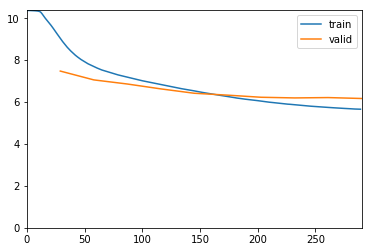

CPU times: user 4h 20min 54s, sys: 12min 45s, total: 4h 33min 40s
Wall time: 1h 22min 45s
2 nb: gc.collect:1339 - used GB memory:13.83


In [22]:
print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
%time learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))
print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [25]:
learn.save('model-32k-sentencepiece-vocab')